In [1]:
from enspara import msm
from enspara import ra
import matplotlib.pyplot as plt
import os
%matplotlib inline

assigs = ra.load('fs-khybrid-clusters0020-assignments.h5')

In [2]:
import numpy as np
from functools import partial

# make 20 different lag times (integers) evenly spaced between 10 and 750
lag_times = np.linspace(10, 750, num=20).astype(int)

implied_timescales = []
for time in lag_times:
    m = msm.MSM(
        lag_time=time,
        method=msm.builders.transpose)
    m.fit(assigs)

    implied_timescales.append(
        -time / np.log(msm.eigenspectrum(m.tprobs_, n_eigs=3)[0][1:3])
    )

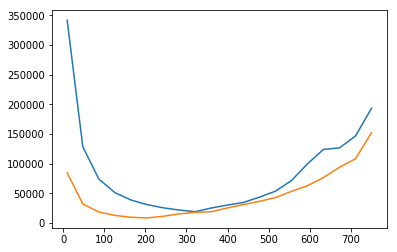

In [3]:
import matplotlib.pyplot as plt

implied_timescales = np.vstack(implied_timescales)

for i in range(implied_timescales.shape[1]):
    plt.plot(lag_times, implied_timescales[:, i],
             label='$\lambda_{%s}$' % (i+1))

In [4]:
m = msm.MSM(
    lag_time=10,
    method=msm.builders.transpose)
m.fit(assigs)

In [5]:
import pickle
import mdtraj as md

with open([x for x in os.listdir() if 'pickle' in x][0], 'rb') as f:
    ctr_structs = md.join(pickle.load(f))

In [6]:
hbonds = md.kabsch_sander(ctr_structs)

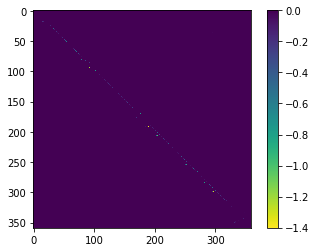

In [7]:
weighted_hbond_mtx = sum(p*h for p, h in zip(m.eq_probs_, hbonds)).todense()
plt.imshow(weighted_hbond_mtx, cmap='viridis_r')
plt.colorbar()

In [8]:
all_hbonds = set()

# accumulate all the possible pairs of residues involved in hbonds
for i in range(len(ctr_structs)):
    donors, acceptors = np.where(hbonds[i].todense() != 0)
    all_hbonds.update([(d, a) for d, a in zip(donors, acceptors)])

# make a list so that it's ordered
all_hbonds = list(all_hbonds)

# this matrix of length n_states will have each binary feature vector
hbond_presence = np.zeros((m.n_states_, len(all_hbonds)),
                          dtype='uint8')

# set each value i, j to one if state i has hbond j.
for i in range(len(ctr_structs)):
    donors, acceptors = np.where(hbonds[i].todense() != 0)

    for a, d in zip(donors, acceptors):
        hbond_id = all_hbonds.index((a, d))
        hbond_presence[i, hbond_id] = 1

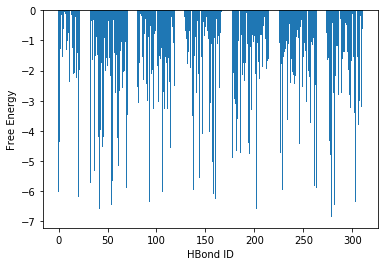

In [9]:
p_hbond = np.dot(m.eq_probs_, hbond_presence)

plt.bar(np.arange(len(all_hbonds)), height=np.log(p_hbond))
plt.ylabel("Free Energy")
plt.xlabel("HBond ID")
plt.savefig('./hbond-free-energy.svg')

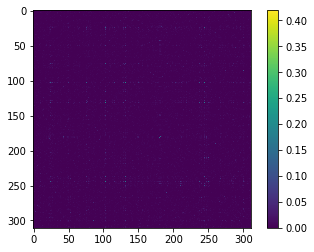

In [10]:
from enspara.info_theory import weighted_mi

hbond_mi = weighted_mi(features=hbond_presence, weights=m.eq_probs_)
hbond_mi = hbond_mi - np.diag(np.diag(hbond_mi))

plt.imshow(hbond_mi - np.diag(np.diag(hbond_mi)))
plt.colorbar()

In [11]:
hbond1, hbond2 = np.unravel_index(hbond_mi.argmax(), hbond_mi.shape)

def hbond2str(pair, top):
   return '⟶'.join([str(top.residue(i)) for i in pair])

hbond2str(all_hbonds[hbond1], ctr_structs.top), hbond2str(all_hbonds[hbond2], ctr_structs.top)

('PRO321⟶ILE320', 'TRP219⟶LYS223')

In [20]:
import msmbuilder.tpt
from sklearn.model_selection import learning_curve, GridSearchCV

from enspara import tpt
from enspara.msm import MSM, builders

msm = MSM(lag_time=10, method=builders.transpose)
msm.fit(assignments)

source_state = 1
sink_state = 100

# compute the net flux matrix from our
nfm = tpt.net_fluxes(
    msm.tprobs_,
    source_state, sink_state,
    populations=msm.eq_probs_)

path, flux = msmbuilder.tpt.top_path(maximizer_ind, minimizer_ind, nfm.todense())

NameError: name 'maximizer_ind' is not defined

In [23]:
import mdtraj as md
from enspara import geometry
import enspara

pdb = md.load([x for x in os.listdir() if 'pdb' in x])

# run ligsite
pockets_xyz = enspara.geometry.get_pocket_cells(struct=pdb)

# build a pdb of hydrogen atoms for each grid point so it can be
# examined in a visualization program (e.g. pymol)
import pandas as pd

top_df = pd.DataFrame()
top_df['serial'] = range(len(pockets_grid_points))
top_df['name'] = 'PK'
top_df['element'] = 'H'
top_df['resSeq'] = range(len(pockets_grid_points))
top_df['resName'] = 'PCK'
top_df['chainID'] = 0

pocket_top = md.Topology.from_dataframe(top_df, np.array([]))
pocket_trj = md.Trajectory(xyz=pockets_xyz, topology=pocket_top)
pocket_trj.save('./pockets.pdb')

NameError: name 'pockets_grid_points' is not defined